# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [7]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

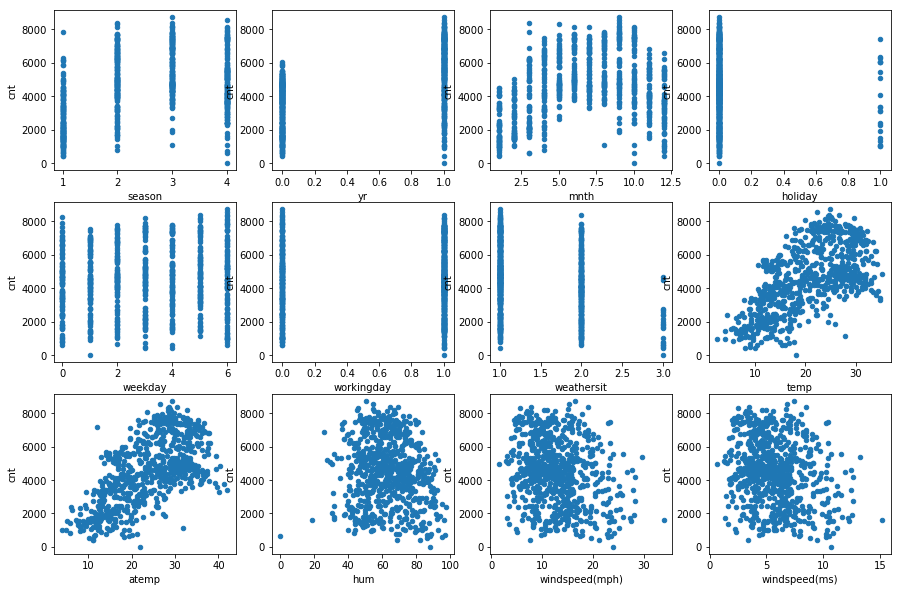

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ:
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp(температура), atemp(температура по ощущениям)

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [107]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
cnt_df = df.cnt
#all_fich = df.loc[:,['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']]
all_fich = df[df.columns[:-1]]  

correl = all_fich.corrwith(cnt_df)
correl


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [69]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
several_fich = df.loc[:,['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
several_fich [:5]
correl_several_fich = several_fich.corr()
correl_several_fich


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [87]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков

df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [88]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [89]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [108]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns


In [122]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
linear_regressor.coef_

array([  5.70867312e+02,   1.02196753e+03,  -1.41300874e+02,
        -8.67617542e+01,   1.37224639e+02,   5.63866909e+01,
        -3.30229759e+02,   3.67478509e+02,   5.85552560e+02,
        -1.45611173e+02,   1.24557271e+13,  -1.24557271e+13])

In [123]:

print zip(df.columns,linear_regressor.coef_)

[('season', 570.86731203886427), ('yr', 1021.9675349977184), ('mnth', -141.30087442555225), ('holiday', -86.76175420768169), ('weekday', 137.22463919710077), ('workingday', 56.386690870594293), ('weathersit', -330.22975919975073), ('temp', 367.47850939492275), ('atemp', 585.55255993993057), ('hum', -145.61117341986551), ('windspeed(mph)', 12455727061390.27), ('windspeed(ms)', -12455727061588.725)]


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [124]:
from sklearn.linear_model import Lasso, Ridge

In [125]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса


In [133]:
lasso_regressor = Lasso(random_state = 3)
lasso_regressor.fit(X, y)
print zip(df.columns,lasso_regressor.coef_)


[('season', 560.24161603088703), ('yr', 1019.4634940657198), ('mnth', -128.73062703678787), ('holiday', -86.152781333710607), ('weekday', 137.347893904963), ('workingday', 55.212370641356699), ('weathersit', -332.36985696234836), ('temp', 376.36323620969745), ('atemp', 576.53079350455221), ('hum', -144.12915500348586), ('windspeed(mph)', -197.13968940248643), ('windspeed(ms)', -2.8049135112449552e-08)]


In [ ]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса


In [134]:
ridge_regressor = Ridge(random_state = 3)
ridge_regressor.fit(X, y)
print zip(df.columns,ridge_regressor.coef_)

[('season', 563.06457225201268), ('yr', 1018.9483787875284), ('mnth', -131.87332028247275), ('holiday', -86.74609799709242), ('weekday', 138.00511117871912), ('workingday', 55.903110375064529), ('weathersit', -332.34978849907287), ('temp', 386.4578891919179), ('atemp', 566.34704706005834), ('hum', -145.07132729867268), ('windspeed(mph)', -99.259441081804027), ('windspeed(ms)', -99.259441154328826)]


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [139]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
alphas


array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451])

In [157]:
for i in range(len(alphas)):
    
    lasso_regressor_a = Lasso(alpha=alphas[i], random_state = 3)
    w = lasso_regressor_a.fit(X, y)
    coefs_lasso[i] = w.coef_

print coefs_lasso

[[  5.60241616e+02   1.01946349e+03  -1.28730627e+02  -8.61527813e+01
    1.37347894e+02   5.52123706e+01  -3.32369857e+02   3.76363236e+02
    5.76530794e+02  -1.44129155e+02  -1.97139689e+02  -2.80491351e-08]
 [  4.10969632e+02   9.77019409e+02  -0.00000000e+00  -5.34489688e+01
    9.19434374e+01   1.75372118e+01  -3.18125568e+02   3.22829934e+02
    6.10031512e+02  -9.10689615e+01  -1.45066095e+02  -2.29864422e-08]
 [  3.70077089e+02   9.35945490e+02   0.00000000e+00  -1.21619360e+01
    4.88886342e+01   0.00000000e+00  -3.08805664e+02   2.69417263e+02
    6.32502623e+02  -2.75042876e+01  -9.37749037e+01  -2.41645601e-08]
 [  3.32835717e+02   8.91870058e+02   0.00000000e+00  -0.00000000e+00
    0.00000000e+00   0.00000000e+00  -2.79616688e+02   2.11052030e+02
    6.62920880e+02  -0.00000000e+00  -5.01551472e+01  -2.62783303e-08]
 [  2.98134448e+02   8.45652857e+02   0.00000000e+00  -0.00000000e+00
    0.00000000e+00   0.00000000e+00  -2.35571345e+02   1.24144807e+02
    7.25379483e+

In [158]:
for i in range(len(alphas)):
    
    ridge_regressor_a = Ridge(alpha=alphas[i], random_state = 3)
    w = ridge_regressor_a.fit(X, y)
    coefs_ridge[i] = w.coef_

print coefs_ridge

[[  563.06457225  1018.94837879  -131.87332028   -86.746098     138.00511118
     55.90311038  -332.3497885    386.45788919   566.34704706  -145.0713273
    -99.25944108   -99.25944115]
 [  461.1786324    954.30774189   -41.56545001   -84.91347027
    126.60366663    54.2516911   -313.27515141   458.90147709
    481.44350031  -151.29101033  -101.62731482  -101.62731483]
 [  403.97653045   898.08362212     5.67424346   -81.91106159
    117.94141144    52.72848389  -298.40898086   455.28986839
    467.43141748  -152.68605059  -102.10167084  -102.10167084]
 [  366.60423851   848.46346471    34.02728278   -78.77196479
    110.68012006    51.25719208  -286.12515935   447.47982533
    455.75402966  -151.48320603  -102.00537592  -102.00537593]
 [  339.74528956   804.25104797    52.48987295   -75.71740756
    104.40346414    49.84189502  -275.48609488   438.50968939   444.7642744
   -148.94396978  -101.58638458  -101.58638458]
 [  319.15864133   764.5614337     65.15200737   -72.81970821
     

Визуализируем динамику весов при увеличении параметра регуляризации:

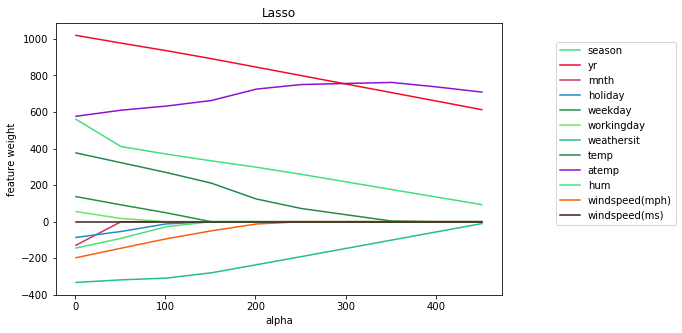

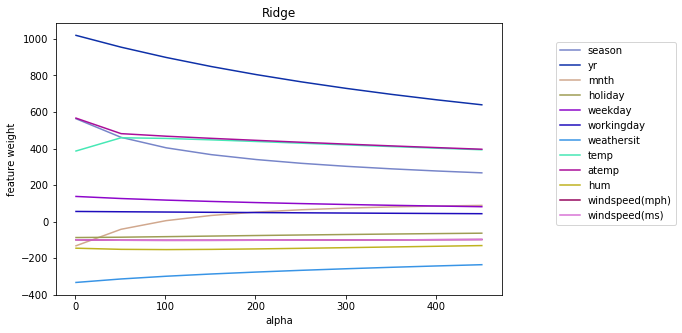

In [162]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: они обнулятся, поскольку алгоритму покажется что они линейно зависимы. Чем больше альфа, тем легче он видит линейную зависимость, даже если ее там нет.
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:   Да, Lasso исключает один из признаков windspeed при любом значении alpha > 0. Ridge - не исключает, но делает оба признака windspeed равными, что тоже легко найти и исключить один из них самостоятельно.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: оба подойдут 

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [173]:
from sklearn.linear_model import LassoCV

In [175]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
alphas

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])

In [192]:
lassoCV_regressor = LassoCV(random_state = 3, alphas = alphas)
lassoCV_regressor.fit(X, y)



print('выбранное значение альфа:  ' + str(lassoCV_regressor.alpha_))
print(' ')
print('выбранное значение весов: ' + str(lassoCV_regressor.coef_))
print(' ')
print('пары признак-коэффициент')
print zip(df.columns,lassoCV_regressor.coef_)

выбранное значение альфа:  6
 
выбранное значение весов: [  5.32018983e+02   1.01506022e+03  -1.00039526e+02  -8.32939599e+01
   1.32504465e+02   5.15570856e+01  -3.30559857e+02   3.70679855e+02
   5.81396931e+02  -1.40007406e+02  -1.91771408e+02  -2.68537057e-08]
 
пары признак-коэффициент
[('season', 532.01898284135348), ('yr', 1015.06022264306), ('mnth', -100.03952614356615), ('holiday', -83.293959875299095), ('weekday', 132.50446549095778), ('workingday', 51.557085614074012), ('weathersit', -330.55985673998094), ('temp', 370.67985503003513), ('atemp', 581.39693106549657), ('hum', -140.0074055006888), ('windspeed(mph)', -191.77140847135155), ('windspeed(ms)', -2.6853705727541121e-08)]


In [180]:
lassoCV_regressor.mse_path_

array([[ 863936.50981215,  826364.11936907,  862993.29751895],
       [ 860479.31511365,  821110.1817776 ,  853075.13780625],
       [ 857344.83606082,  816153.27782428,  843628.81286098],
       [ 854526.73639431,  811496.34805693,  834654.45357262],
       [ 852024.62341384,  807139.39657173,  826152.16399015],
       [ 849838.18755425,  803082.42338526,  818122.01934907],
       [ 847967.16232762,  799325.42849761,  810564.07404745],
       [ 846411.31812808,  795868.41190876,  803478.36741509],
       [ 845170.45707972,  792711.37361871,  796864.92788593],
       [ 844244.40861679,  789854.31362747,  790723.77601555],
       [ 843633.02568868,  787297.23193504,  785058.69560905],
       [ 843336.18149882,  785040.12854141,  779861.12465128],
       [ 843353.76670095,  783083.00344659,  775139.90236011],
       [ 843616.44582031,  781425.85665058,  770886.43550572],
       [ 843608.19759457,  780068.68815337,  767109.44006007],
       [ 844145.56423514,  777586.36117475,  763800.364

In [193]:
lassoCV_regressor.alphas_

array([96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16,
       11,  6,  1])

In [196]:
print zip(lassoCV_regressor.alphas_,lassoCV_regressor.mse_path_)

[(96, array([ 863936.50981215,  826364.11936907,  862993.29751895])), (91, array([ 860479.31511365,  821110.1817776 ,  853075.13780625])), (86, array([ 857344.83606082,  816153.27782428,  843628.81286098])), (81, array([ 854526.73639431,  811496.34805693,  834654.45357262])), (76, array([ 852024.62341384,  807139.39657173,  826152.16399015])), (71, array([ 849838.18755425,  803082.42338526,  818122.01934907])), (66, array([ 847967.16232762,  799325.42849761,  810564.07404745])), (61, array([ 846411.31812808,  795868.41190876,  803478.36741509])), (56, array([ 845170.45707972,  792711.37361871,  796864.92788593])), (51, array([ 844244.40861679,  789854.31362747,  790723.77601555])), (46, array([ 843633.02568868,  787297.23193504,  785058.69560905])), (41, array([ 843336.18149882,  785040.12854141,  779861.12465128])), (36, array([ 843353.76670095,  783083.00344659,  775139.90236011])), (31, array([ 843616.44582031,  781425.85665058,  770886.43550572])), (26, array([ 843608.19759457,  78

In [204]:
lassoCV_regressor_MSE_MEAN = np.zeros(lassoCV_regressor.alphas_.shape[0]) # матрица весов размера (число регрессоров) x (число признаков)
for i in range(len(lassoCV_regressor.alphas_)):
    m = []
    mse_i = 0
    m = lassoCV_regressor.mse_path_[i]
    mse_i = (m[0] + m[1] + m[2])/3
    lassoCV_regressor_MSE_MEAN [i] = mse_i
    

In [205]:
lassoCV_regressor_MSE_MEAN

array([ 851097.97556673,  844888.21156583,  839042.30891536,
        833559.17934129,  828438.72799191,  823680.87676286,
        819285.55495756,  815252.69915065,  811582.25286145,
        808274.1660866 ,  805329.65107759,  802745.81156384,
        800525.55750255,  798642.91265887,  796928.77526934,
        795177.42985684,  793826.01832989,  792028.11513622,
        790397.72811014,  825435.81203949])

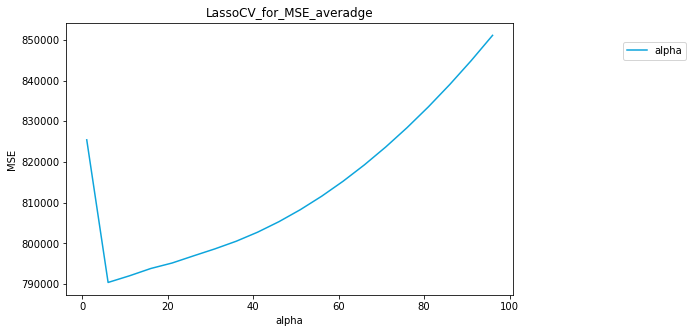

In [215]:
plt.figure(figsize=(8, 5))
plt.plot(lassoCV_regressor.alphas_, lassoCV_regressor_MSE_MEAN, label='alpha', color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV_for_MSE_averadge")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [ ]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_


In [216]:
lassoCV_regressor_MSE_1 = np.zeros(lassoCV_regressor.alphas_.shape[0]) # матрица весов размера (число регрессоров) x (число признаков)
lassoCV_regressor_MSE_2 = np.zeros(lassoCV_regressor.alphas_.shape[0])
lassoCV_regressor_MSE_3 = np.zeros(lassoCV_regressor.alphas_.shape[0])
for i in range(len(lassoCV_regressor.alphas_)):
    m = []
    mse_i = 0
    m = lassoCV_regressor.mse_path_[i]
    
    lassoCV_regressor_MSE_1 [i] = m[0]
    lassoCV_regressor_MSE_2 [i] = m[1]
    lassoCV_regressor_MSE_3 [i] = m[2]

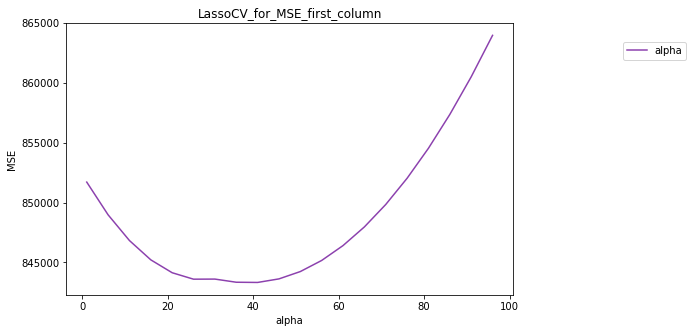

In [217]:
plt.figure(figsize=(8, 5))
plt.plot(lassoCV_regressor.alphas_, lassoCV_regressor_MSE_1, label='alpha', color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV_for_MSE_first_column")

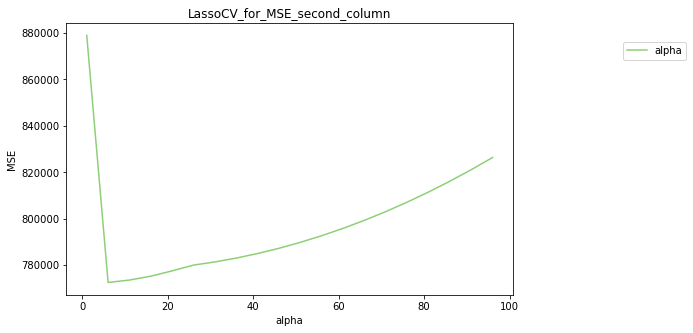

In [218]:
plt.figure(figsize=(8, 5))
plt.plot(lassoCV_regressor.alphas_, lassoCV_regressor_MSE_2, label='alpha', color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV_for_MSE_second_column")

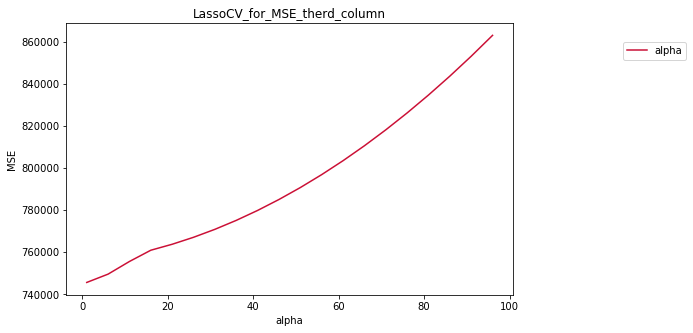

In [219]:
plt.figure(figsize=(8, 5))
plt.plot(lassoCV_regressor.alphas_, lassoCV_regressor_MSE_3, label='alpha', color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV_for_MSE_therd_column")

In [ ]:
lassoCV_regressor_MSE_1 = np.zeros(lassoCV_regressor.alphas_.shape[0]) # матрица весов размера (число регрессоров) x (число признаков)
lassoCV_regressor_MSE_2 = np.zeros(lassoCV_regressor.alphas_.shape[0])
lassoCV_regressor_MSE_3 = np.zeros(lassoCV_regressor.alphas_.shape[0])
for i in range(len(lassoCV_regressor.alphas_)):
    m = []
    mse_i = 0
    m = lassoCV_regressor.mse_path_[i]
    
    lassoCV_regressor_MSE_1 [i] = m[0]
    lassoCV_regressor_MSE_2 [i] = m[1]
    lassoCV_regressor_MSE_3 [i] = m[2]

In [232]:
def min_alph(MSE_min, MSE):
    for i in range(len(lassoCV_regressor.alphas_)):
        if (MSE[i] == MSE_min): return lassoCV_regressor.alphas_[i]




In [236]:
a1 = min_alph(lassoCV_regressor_MSE_1.min(), lassoCV_regressor_MSE_1)
a2 = min_alph(lassoCV_regressor_MSE_2.min(), lassoCV_regressor_MSE_2)
a3 = min_alph(lassoCV_regressor_MSE_3.min(), lassoCV_regressor_MSE_3)
print('в столбце 1 минимальное значение ошибки  ' + str(lassoCV_regressor_MSE_1.min()) + ' , при этом альфа = ' + str (a1)  )
print('в столбце 2 минимальное значение ошибки  ' + str(lassoCV_regressor_MSE_2.min()) + ' , при этом альфа = ' + str (a2)  )
print('в столбце 3 минимальное значение ошибки  ' + str(lassoCV_regressor_MSE_3.min()) + ' , при этом альфа = ' + str (a3)  )

в столбце 1 минимальное значение ошибки  843336.181499 , при этом альфа = 41
в столбце 2 минимальное значение ошибки  772598.495628 , при этом альфа = 6
в столбце 3 минимальное значение ошибки  745668.605961 , при этом альфа = 1


На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

In [237]:
print('выбранное значение альфа:  ' + str(lassoCV_regressor.alpha_))
print(' ')
print('выбранное значение весов: ' + str(lassoCV_regressor.coef_))
print(' ')
print('пары признак-коэффициент')
print zip(df.columns,lassoCV_regressor.coef_)

выбранное значение альфа:  6
 
выбранное значение весов: [  5.32018983e+02   1.01506022e+03  -1.00039526e+02  -8.32939599e+01
   1.32504465e+02   5.15570856e+01  -3.30559857e+02   3.70679855e+02
   5.81396931e+02  -1.40007406e+02  -1.91771408e+02  -2.68537057e-08]
 
пары признак-коэффициент
[('season', 532.01898284135348), ('yr', 1015.06022264306), ('mnth', -100.03952614356615), ('holiday', -83.293959875299095), ('weekday', 132.50446549095778), ('workingday', 51.557085614074012), ('weathersit', -330.55985673998094), ('temp', 370.67985503003513), ('atemp', 581.39693106549657), ('hum', -140.0074055006888), ('windspeed(mph)', -191.77140847135155), ('windspeed(ms)', -2.6853705727541121e-08)]


In [270]:

ans = zip(df.columns,lassoCV_regressor.coef_)
ansv = pd.DataFrame(ans)
ansv.columns = ["fich", "weights"]
ansv.sort_values(by = "weights")


,fich,weights
6,weathersit,-3.305599e+02
10,windspeed(mph),-1.917714e+02
9,hum,-1.400074e+02
2,mnth,-1.000395e+02
3,holiday,-8.329396e+01
11,windspeed(ms),-2.685371e-08
5,workingday,5.155709e+01
4,weekday,1.325045e+02
7,temp,3.706799e+02
0,season,5.320190e+02


4 признака с наибольшими (положительными) коэфициентами: 
('yr', 1015.06022264306)
('atemp', 581.39693106549657),
('season', 532.01898284135348)
('temp', 370.67985503003513),


__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: 
    
4 признака с наибольшими (положительными) коэфициентами: 

('yr', 1015.06022264306)   -      зависимость есть, но надо еще посмотреть количество по годам в целом, может быть во второй год просто больше народу пользовалось прокатом и выборки не сранимы по размеру, отсюда перекос. С другой стороны, возможно этот фактор в целом значимый, тк с каждым годом люди привыкают к тому, что можно взять велосипед и поэтому можно предположить, что несколько лет этот показатель будет расти (пока все, кто потенциально может взять велосипед на прокат не узнают об услуге и не начнут пользоваться прокатом). Так что по этому пункту будет рост какое-то время с последующим выходом зависимоти в насыщение.

('atemp', 581.39693106549657)  - зависимость есть и это логично. Сказать, что рост этого признака повлияет на увеличение прокатов - врядли можно, тк при 50 градусах цельсия, наверное, не многие рискнут покататься. Значит для этой зависимости есть некоторый доверительный интервал, возможно с нормальным распределением и немного растянутый в одну из сторон (поскольку мы не рассматривали как часто вообще бывает в этом районе погода подходящая для катания и что люди живущие там понимают под "комфортной температурой для катания". Если это Техас - одно дело, если Петербург - другое). Но в любом случае, похоже, что это самый информативный признак из всех в таблице. 

('season', 532.01898284135348) - зависимость есть, хоть и не очень бросающаяся в глаза, возможно данные для довольно теплого климата. Врядли в СПб или МСК можно ожидать такой маленькой разницы в количестве прокатов летом и зимой. Зависимость довольно логичная из общих соображений и то, что ее показала модель, не очень удивительно. Но наверное стоит посмотреть подробнее на этот столбеи и возможно построить немного другие графики для него, чтобы увидеть более ярко выраженую закономерность "глазами". На этом графике не скажешь, что это третий по значимости признак.


('temp', 370.67985503003513) - Зависимость есть, очень ярко выраженая, линейная и к ней в целом подходят рассуждения для столбца atemp. И то, что можель показала влияние реальной температуры меньше, чем температуры "по-ощущениям" - очень логично. +15 весной с ледяным ветром и +15 ранней осенью с южным ветром - действительно разные вещи.   


В целом, основные признаки по модели в целом - это температура (оба столбца) и время года, что вполне логично. И на данном этапе развития велопроката в представленных данных год вышел на первое место, и по тому с какой скоростью наблюдается рост по этому параметру, в городе еще идет освоение рынка проката, и какое-то время рост от года к году будет. Но в целом, как только рынок насытится, на первое место выйдут параметры температуры и времени года. 

   
    
    
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ:
    weathersit	    -330.6 
    windspeed(mph)	-191.8  
    hum	            -140.0 

    weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман). Зависимость видна, хоть на таком графике ее смотреть не очень удобно. Довольно логично, что она есть. Отрицательная она из-за определения этого признака, 4 - самая плохая погода, 1 - самая хорошая. Логично утверждать, что чем эта величина больше, тем тем меньше людей захотят взять велосипеды.
    
    Скорость ветра. На картинке присутствует некоторая зависимость, но не линейная. Скорее зависимость нормальная с большим весом слева. Что логично, поскольку в штормовой ветер кататься неудобно, а в штиль вполне можно. Здесть опять же важно принять во внимание есть ли вобще штормовые дни или штиль в данной местности. И после этого можно делать выводы о поведении людей. Хотя явное влияние этого фактора должно быть и из модели видно, если ветер меньше, то велосипеды берут чаще. 
    
    Влажность. График для влажности похож на график для скорости ветра. И рассуждения будут теми же. Есть некий оптимум похожий на нормальное распределение, когда люди берут велосипеды чаще. В области низких показателей влажности велосипеды почти не берут, но возможно в этом городе просто небыло настолько сухих дней. Зависимость есть, она не линейная. По модели выходит, что чем меньше влажность, тем больше берут велосипедов, до некоторой степени это логично, но не вполне. Поскольку опять же зависит какие вообще бывают разбросы влажности в этой местности. И, например, в Петербурге в 95-100% влажности дождик идет не всегда и люди вполне живут и катаются на велосипедах, и они может быть чаще бы брали прокат при влажности меньше 60%, но такого у нас почти не бывает. 
    
    
    
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ:
    
    holiday	        -83.3 
    windspeed(ms)	-2.7 * e-08
    workingday	     51.6
    
    
    holiday: 0 - нет праздника, 1 - есть праздник. Зависимость на графике очень ярко выраженая, можель не показала такой зависимости. По всей видимости надо было по другому обрабатывать данные этого столбца. И при этом учесть количество праздничных и не праздничных дней (нормировать). На данный момент по графику видно, что чаще берут в не праздничные дни. Либо ездят на велосипедах на работу - что вполне вероятно, либо непраздничных дней просто намного больше, ответить на этот вопрос поможет нормировка. 
    
    windspeed(ms) - можель исключила этот параметр, поскольку он линейно зависимый, мы этого и добивались.
    
    workingday: 0 - нерабочий день, 1 - рабочий день. Та же беда, что и с праздничными - днями, но с другим знаком. (разница следует из определения - в holiday нерабочий день - 1, в workingday - 0). Некорректро было использовать этот столбец без нормировки. Зависимости на графике почти не видно, надо было другой для этого столбца построить, более информативный. 
    
    По столбцам holiday и workingday нужно еще изучать ситуацию, данная модель не показала их влияния, но возможно влияние есть.  
    

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.